In [17]:
%cd /content/drive/MyDrive/Digital_Image_Processing_EE608

/content/drive/MyDrive/Digital_Image_Processing_EE608


In [25]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 209.23 KiB | 11.01 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/shashankkapoor/Digital_Image_Processing_EE608.git
   7589c10..acbebe3  master -> master


In [19]:
!git config --global user.email "Shashankkapoor1994@gmail.com"
!git config --global user.name  "Shashank kapoor"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import cv2  # for Hough Transform only
import random
import numpy as np
from scipy import ndimage
from skimage.morphology import square, rectangle, closing, opening



In [8]:
''' change the path here to run the below code
'''
gray_image_path="/content/drive/MyDrive/Images_HWS/DIP_gray_scales/Cameraman - Copy.tif"
#histogram_image_path="/content/drive/MyDrive/Images_HWS/DIP_gray_scales/Fingerprint - Copy.tif"

# Problem 1: SSIM Index

#### 1. Write a program to implement the SSIM index. Your program should also display the SSIM map. Generate test images by adding noise, blurring and compressing the reference image (all separately)

In [51]:
def add_gaussian_noise(image, mean, std_dev):
    image_array = np.array(image)
    noise = np.zeros(image_array.shape, dtype=np.float32)
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            noise[i, j] = random.gauss(mean, std_dev)
    noisy_image = image_array + noise
    noisy_image = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min()) * 255
    return Image.fromarray(noisy_image.astype(np.uint8))

def bluring(image, kernel_size):
  blur = np.zeros(np.shape(image), dtype='int')
  kernel = np.ones((kernel_size,kernel_size), dtype = 'int')
  pad_size=kernel.shape[0]//2
  padded_image=np.pad(image,pad_size,mode='constant')
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      div = 1/((kernel.shape[0])*(kernel.shape[1]))
      blur[i][j] = div * np.sum(kernel * padded_image[i:i+kernel_size, j:j+kernel_size])
  return blur




In [52]:
def luminance_similarity(img1, img2, window_size=11, C1=0.01):
    pad_size = window_size // 2
    img1 = np.pad(img1, pad_size, mode='constant')
    img2 = np.pad(img2, pad_size, mode='constant')
    w = np.ones((window_size, window_size)) / window_size ** 2
    mu1 = np.zeros(img1.shape)
    mu2 = np.zeros(img2.shape)
    for i in range(pad_size, img1.shape[0] - pad_size):
        for j in range(pad_size, img1.shape[1] - pad_size):
            mu1[i,j] = np.sum(w * img1[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])
            mu2[i,j] = np.sum(w * img2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])
    mu1 = np.sum(mu1)
    mu2 = np.sum(mu2)
    num = 2 * mu1 * mu2 + C1
    denom = mu1 ** 2 + mu2 ** 2 + C1
    l = num / denom
    return l

def contrast_similarity(ref_image, dist_image, window_size=11, C2=(0.03*255)**2):
    pad_size = window_size // 2
    img1 = np.pad(ref_image, pad_size, mode='constant')
    img2 = np.pad(dist_image, pad_size, mode='constant')
    w = np.ones((window_size, window_size)) / window_size ** 2
    mu1 = np.zeros(img1.shape)
    mu2 = np.zeros(img2.shape)
    sig1 = np.zeros(img1.shape)
    sig2 = np.zeros(img2.shape)
    for i in range(pad_size, img1.shape[0] - pad_size):
        for j in range(pad_size, img1.shape[1] - pad_size):
            mu1[i, j] = np.sum(w * img1[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])
            mu2[i, j] = np.sum(w * img2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])
            sig1[i, j] = (np.sum(w * (img1[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] - mu1[i, j])**2))
            sig2[i, j] = (np.sum(w * (img2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] - mu2[i, j])**2))
    sig1 = (np.sum(sig1))**0.5
    sig2 = (np.sum(sig2))**0.5
    contrast_similarity = ((2 * sig1 * sig2) + C2)/ ((sig1**2) + (sig2**2) + C2)
    return contrast_similarity

def structural_similarity(ref_image, dist_image, window_size=11, C3=((0.03*255)**2)/2):
    pad_size = window_size // 2
    img1 = np.pad(ref_image, pad_size, mode='constant')
    img2 = np.pad(dist_image, pad_size, mode='constant')
    w = np.ones((window_size, window_size)) / window_size ** 2
    mu1 = np.zeros(img1.shape)
    mu2 = np.zeros(img2.shape)
    sig1 = np.zeros(img1.shape)
    sig2 = np.zeros(img2.shape)
    for i in range(pad_size, img1.shape[0] - pad_size):
        for j in range(pad_size, img1.shape[1] - pad_size):
            mu1[i, j] = np.sum(w * img1[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])
            mu2[i, j] = np.sum(w * img2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])
            sig1[i, j] = (np.sum(w * (img1[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] - mu1[i, j])**2))
            sig2[i, j] = (np.sum(w * (img2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] - mu2[i, j])**2))
    sig_ij = np.zeros(img2.shape)
    for i in range(pad_size, img1.shape[0] - pad_size):
        for j in range(pad_size, img1.shape[1] - pad_size):
            sig_ij[i, j] = np.sum(w * [(img1[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] - mu1[i,j])* (img2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] - mu2[i,j])])
    sig1 = (np.sum(sig1))**0.5
    sig2 = (np.sum(sig2))**0.5
    sig_ij = np.sum(sig_ij)
    structural = (sig_ij + C3)/ (sig1 * sig2 + C3)
    return structural

Text(0.5, 1.0, 'Noisy Image')

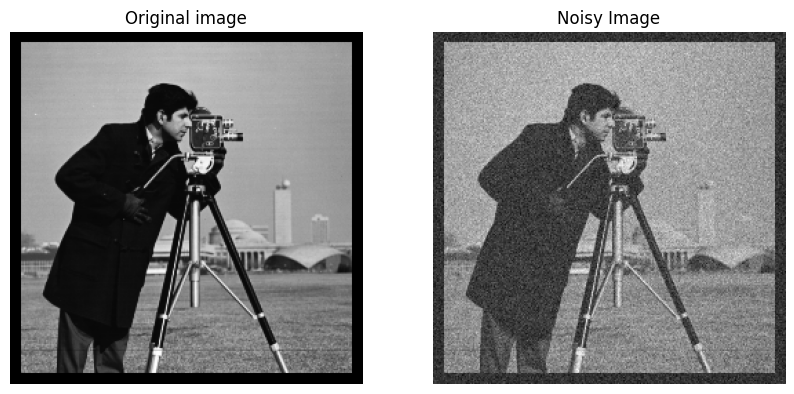

In [56]:
gray_image=np.array(Image.open(gray_image_path))
mean = 0
std_dev = 20
noisy_image = add_gaussian_noise(gray_image,mean,std_dev)

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.title("Noisy Image")

Text(0.5, 1.0, 'Blur image')

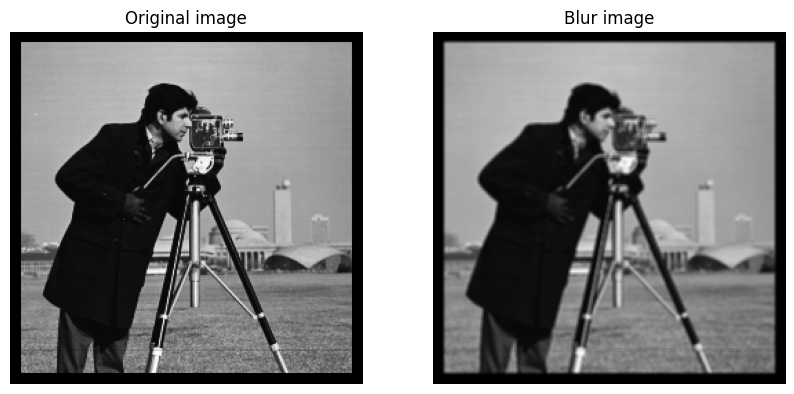

In [57]:
image = np.array(gray_image)
kernel_size = 3
blur = bluring(image,kernel_size)

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(blur, cmap='gray')
plt.axis('off')
plt.title("Blur image")

SSIM for noise:  0.8342284789586758


Text(0.5, 1.0, 'Noisy Image')

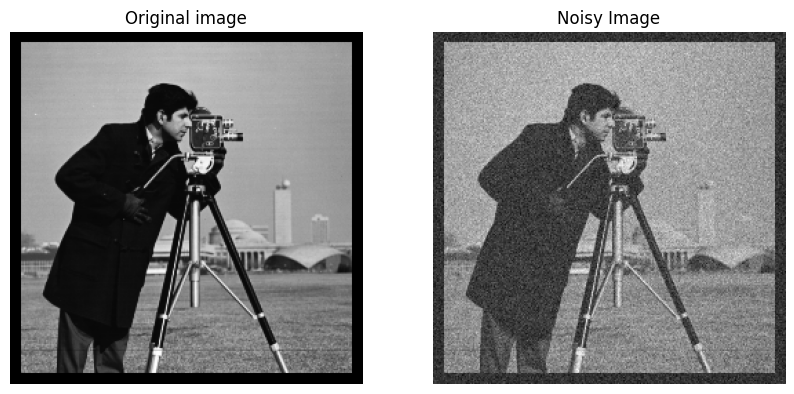

In [62]:
luminance_noise = luminance_similarity(np.array(gray_image), np.array(noisy_image))
contrast_noise = contrast_similarity(np.array(gray_image), np.array(noisy_image))
structural_noise = structural_similarity(np.array(gray_image), np.array(noisy_image))

ssim_noise = luminance_noise*contrast_noise*structural_noise
print('SSIM for noise: ',ssim_noise)

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.title("Noisy Image")

SSIM for blur:  0.9070465865546203


Text(0.5, 1.0, 'blur Image')

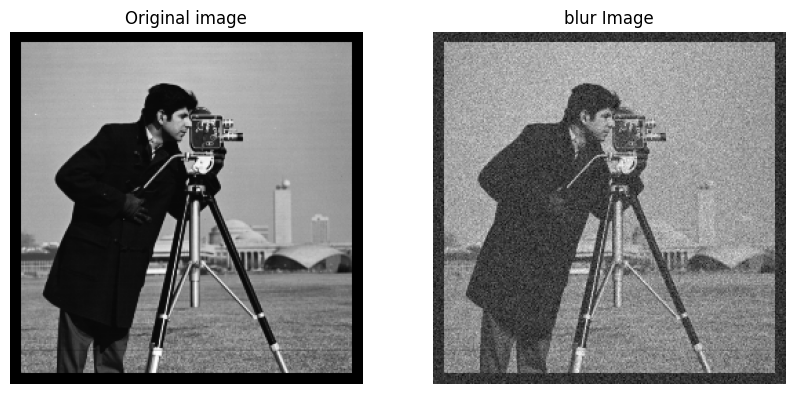

In [61]:
luminance_blur = luminance_similarity(np.array(gray_image), np.array(blur))
contrast_blur = contrast_similarity(np.array(gray_image), np.array(blur))
structural_blur = structural_similarity(np.array(gray_image), np.array(blur))

ssim_blur = luminance_blur*contrast_blur*structural_blur
print('SSIM for blur: ',ssim_blur)

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.title("blur Image")

# Problem 2: Harris Corner Detection

#### 1. Implement Harris Corner Detection Algorithm

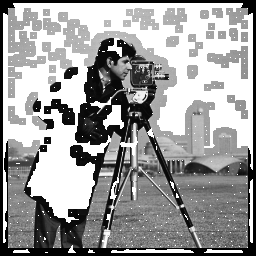

In [40]:
img = Image.open(gray_image_path)
img_arr = np.array(img)

dx = signal.convolve2d(img_arr, [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], boundary='symm', mode='same')
dy = signal.convolve2d(img_arr, [[-1, -2, -1], [0, 0, 0], [1, 2, 1]], boundary='symm', mode='same')

Ixx = dx * dx
Ixy = dx * dy
Iyy = dy * dy

sigma = 1
ksize = int(2 * np.ceil(3 * sigma) + 1)
gaussian = np.zeros((ksize, ksize))
for i in range(ksize):
    for j in range(ksize):
        gaussian[i, j] = np.exp(-(i - ksize // 2)**2 / (2 * sigma**2) - (j - ksize // 2)**2 / (2 * sigma**2))
gaussian /= np.sum(gaussian)
Ixx = signal.convolve2d(Ixx, gaussian, boundary='symm', mode='same')
Ixy = signal.convolve2d(Ixy, gaussian, boundary='symm', mode='same')
Iyy = signal.convolve2d(Iyy, gaussian, boundary='symm', mode='same')

k = 0.04
det = (Ixx * Iyy) - (Ixy * Ixy)
trace = Ixx + Iyy
harris = det - k * trace**2

threshold = 10000
harris[harris < threshold] = 0

radius = 3
for i in range(radius, harris.shape[0] - radius):
    for j in range(radius, harris.shape[1] - radius):
        if harris[i, j] == np.max(harris[i - radius:i + radius + 1, j - radius:j + radius + 1]):
            img_arr[i, j] = 255

result_img = Image.fromarray(img_arr)
result_img.show()


# Problem 3: Hough Transform

#### 1. Implement Hough Transform to detect lines and circles using OPEN-CV.

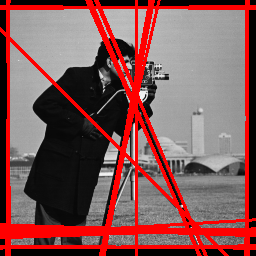

In [45]:
from google.colab.patches import cv2_imshow
img = cv2.imread(gray_image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi/360, 100)

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

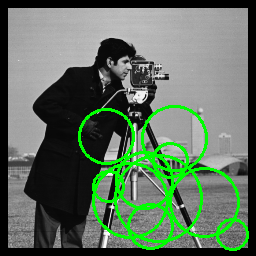

In [48]:
img = cv2.imread(gray_image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=50)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Problem 4: Binary Image Processing


#### 1.Implement the connected components algorithm and use it to label the binarized version of I.Demonstrate your result using any of the gray scale images mentioned above.

In [4]:
def connected_components(img):
    labels = np.zeros(img.shape, dtype=np.uint16)
    label = 1
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] == 255:
                neighbors = []
                if i > 0:
                    if j > 0 and labels[i-1, j-1] > 0:
                        neighbors.append(labels[i-1, j-1])
                    if labels[i-1, j] > 0:
                        neighbors.append(labels[i-1, j])
                    if j < img.shape[1]-1 and labels[i-1, j+1] > 0:
                        neighbors.append(labels[i-1, j+1])
                if j > 0 and labels[i, j-1] > 0:
                    neighbors.append(labels[i, j-1])
                
                if not neighbors:
                    labels[i, j] = label
                    label += 1
                else:
                    labels[i, j] = min(neighbors)
                    for n in neighbors:
                        if n != labels[i, j]:
                            labels[labels == n] = labels[i, j]
    return labels,label


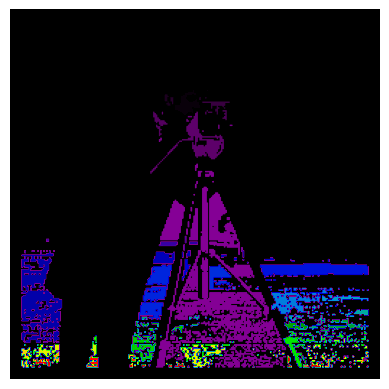

In [9]:
image = np.array(Image.open(gray_image_path))
threshold_value = 127
binarized_image = (image > threshold_value).astype(np.uint8) * 255

labels,_ = connected_components(binarized_image)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
plt.show()

#### 2. Implement minor blob removal to get rid of minor blobs. Demonstrate your result using the gray scale image you used in the previous question.

In [10]:
def remove_minor_blobs(image, threshold):
    labels, num_labels = connected_components(image)
    #print(num_labels)
    sizes = np.zeros(num_labels+1, dtype=int)
    for i in range(1, num_labels+1):
        sizes[i] = np.sum(labels == i)
        #print(sizes[i])

    for i in range(1, num_labels+1):
        if sizes[i] < threshold:
            image[labels == i] = 0
            
    return image

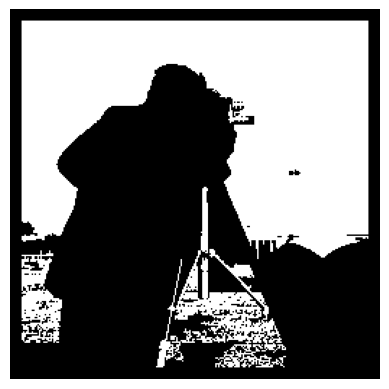

In [37]:
image = np.array(Image.open(gray_image_path))
threshold_value = 127
binarized_image = (image > threshold_value).astype(np.uint8) * 255

threshold_size = 1024
image = remove_minor_blobs(binarized_image, threshold_size)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Problem 5: Binary Morphology

#### 1. Implement the following filters that accept a binary image I and window B as inputs: DILATE, ERODE, MEDIAN. Filter the above binary image using the following windows B = CROSS(5), B = SQUARE(3) (meaning the side of the square window is 3 pixels). Use the binary images generated in the previous assignment as input to this function.

In [38]:
def dilate(binary_image, kernel):
    height, width = binary_image.shape
    h, w = kernel.shape
    padding_h = h // 2
    padding_w = w // 2
    padded_image = np.pad(binary_image, ((padding_h, padding_h), (padding_w, padding_w)), mode='constant', constant_values=0)
    dilated_image = np.zeros((height, width))
    for i in range(padding_h, height + padding_h):
        for j in range(padding_w, width + padding_w):
            if padded_image[i, j] == 1:
                if np.sum(np.logical_and(padded_image[i-padding_h:i+padding_h+1, j-padding_w:j+padding_w+1], kernel)) > 0:
                    dilated_image[i-padding_h, j-padding_w] = 1
    return dilated_image.astype('uint8')

def erode(binary_image, kernel):
    height, width = binary_image.shape
    h, w = kernel.shape
    padding_h = h // 2
    padding_w = w // 2
    padded_image = np.pad(binary_image, ((padding_h, padding_h), (padding_w, padding_w)), mode='constant', constant_values=1)
    eroded_image = np.zeros((height, width))
    for i in range(padding_h, height + padding_h):
        for j in range(padding_w, width + padding_w):
            if padded_image[i, j] == 1:
                if np.sum(np.logical_not(np.logical_xor(padded_image[i-padding_h:i+padding_h+1, j-padding_w:j+padding_w+1], kernel))) == np.sum(kernel):
                    eroded_image[i-padding_h, j-padding_w] = 1
    return eroded_image.astype('uint8')

def median(binary_image, kernel):
    height, width = binary_image.shape
    h, w = kernel.shape
    padding_h = h // 2
    padding_w = w // 2
    padded_image = np.pad(binary_image, ((padding_h, padding_h), (padding_w, padding_w)), mode='constant', constant_values=0)
    median_image = np.zeros((height, width))
    for i in range(padding_h, height + padding_h):
        for j in range(padding_w, width + padding_w):
            median_image[i-padding_h, j-padding_w] = np.median(padded_image[i-padding_h:i+padding_h+1, j-padding_w:j+padding_w+1][kernel == 1])
    return median_image.astype('uint8')


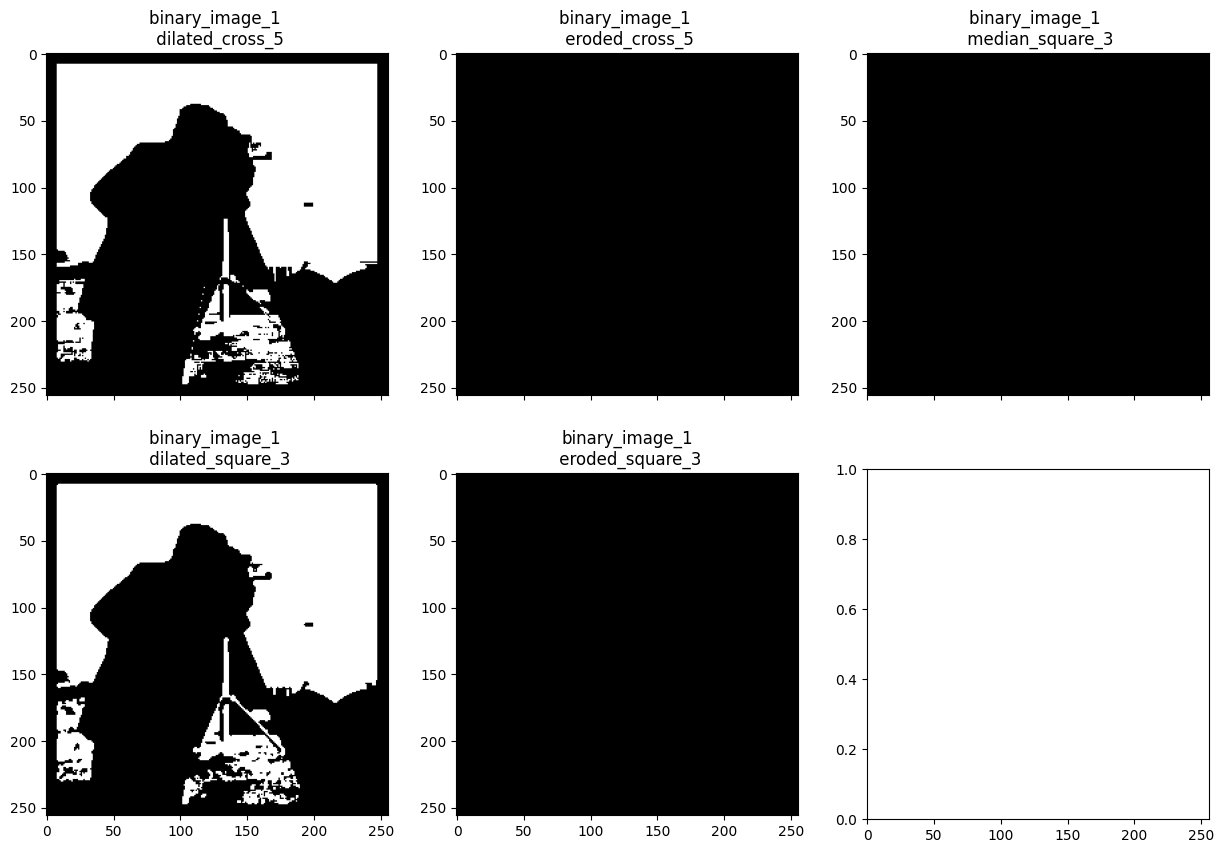

In [39]:
binary_image_1=image
cross_5 = np.array([[0, 0, 1, 0, 0],
                    [0, 0, 1, 0, 0],
                    [1, 1, 1, 1, 1],
                    [0, 0, 1, 0, 0],
                    [0, 0, 1, 0, 0]], dtype=np.uint8)

square_3 = np.ones((3, 3), dtype=np.uint8)

result_1 = []
result_1.append(median(binary_image_1,cross_5))
result_1.append(dilate(binary_image_1, cross_5))
result_1.append(erode(binary_image_1, cross_5))
result_1.append(median(binary_image_1, square_3))
result_1.append(dilate(binary_image_1, square_3))
result_1.append(erode(binary_image_1, square_3))

fig, ax = plt.subplots(2, 3, figsize=(15, 10),sharex=True, )
ax[0,0].set_title("binary_image_1 \n dilated_cross_5")
ax[0,0].imshow(result_1[0], cmap='gray')
ax[0,1].set_title("binary_image_1 \n eroded_cross_5")
ax[0,1].imshow(result_1[1], cmap='gray')
ax[0,2].set_title("binary_image_1 \n median_square_3")
ax[0,2].imshow(result_1[2], cmap='gray')
ax[1,0].set_title("binary_image_1 \n dilated_square_3")
ax[1,0].imshow(result_1[3], cmap='gray')
ax[1,1].set_title("binary_image_1\n eroded_square_3")
ax[1,1].imshow(result_1[4], cmap='gray')
# ax[1,2].set_title("Denoised image M=13")
# ax[1,2].imshow(result_1[0], cmap='gray')




#### 2. Verify that DILATE and ERODE operators are duals of each other with respect to complementation. Also verify that the MEDIAN operator is its own dual with respect to complementation. Show that the difference between the images from the direct and complement paths is indeed zero.

#### 3. Implement the compound operators OPEN and CLOSE using the basic filters implemented above. Use the same windows as in the previous problem. 

#### 4. Finally, implement OPEN-CLOS and CLOS-OPEN. Filter the binary image using the same windows as above.


